# ConSBind Tutorial: Programmatic Usage

This notebook demonstrates how to use the ConSBind package programmatically for predicting protein binding sites.

## Overview

ConSBind (Consensus Structural Binding site predictor) identifies potential binding sites in protein structures using a consensus of geometric and energy-based approaches. This tutorial shows how to:

1. Load protein structures
2. Run binding site predictions
3. Access and analyze prediction results
4. Visualize binding sites

Let's get started!

## Setup

First, let's import the necessary modules and set up logging. If you're running this notebook in a different directory than the ConSBind package, adjust the path accordingly.

In [2]:
import os
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Add parent directory to path if running from examples directory
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

# Import ConSBind modules
from ConSBind.core.structure import ProteinStructure
from ConSBind.core.finder import ConsensusPocketFinder
from ConSBind.core.scoring import final_scoring
from ConSBind.output.output import save_predictions

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('ConSBind-Tutorial')

ImportError: cannot import name 'adjust_scores_by_function' from 'ConSBind.core.scoring' (/Users/claudiavicentecomorera/Desktop/MSc/ConSBind/ConSBind/core/scoring.py)

## Load Protein Structure

First, we'll load a protein structure from a PDB file. ConSBind requires a valid PDB file as input. For this tutorial, we'll use a sample PDB file from the data directory.

Let's define the path to our example PDB file:

In [22]:

import shutil

def convert_ent_to_pdb(ent_file_path):
    """
    Convert a PDB .ent file to .pdb format by copying and renaming the file.
    
    Args:
        ent_file_path (str): Path to the input .ent file
    
    Returns:
        str: Path to the converted .pdb file
    """
    # Check if the input file exists
    if not os.path.exists(ent_file_path):
        raise FileNotFoundError(f"Input file not found: {ent_file_path}")
    
    # Determine the output file path
    file_dir = os.path.dirname(ent_file_path)
    file_name = os.path.splitext(os.path.basename(ent_file_path))[0]
    pdb_file_path = os.path.join(file_dir, f"{file_name}.pdb")
    
    try:
        # Copy the file and rename the extension
        shutil.copy2(ent_file_path, pdb_file_path)
        print(f"Successfully converted {ent_file_path} to {pdb_file_path}")
        return pdb_file_path
    except Exception as e:
        print(f"Error converting file: {e}")
        raise

In [3]:
# Define the path to the PDB file
# Replace with your own PDB file or use a sample one
pdb_file = "data/pdb4dfr.pdb"

# Check if the file exists
if not os.path.exists(pdb_file):
    print(f"Error: PDB file {pdb_file} not found.")
    # You can download a sample PDB file using BioPython
    import Bio.PDB.PDBList
    pdblist = Bio.PDB.PDBList()
    pdb_id = "4dfr"  # Dihydrofolate reductase
    pdblist.retrieve_pdb_file(pdb_id, file_format="pdb", pdir="data")
    pdb_file = "data/pdb4dfr.pdb"
    print(f"Downloaded PDB file to data/pdb{pdb_id}.ent")

# Load the protein structure
try:
    print(f"Loading protein structure from {pdb_file}...")
    output_pdb_file = convert_ent_to_pdb(input_ent_file)
    protein = ProteinStructure(output_pdb_file)
    print("Protein structure loaded successfully!")
except Exception as e:
    print(f"Error loading protein structure: {str(e)}")

Error: PDB file data/pdb4dfr.pdb not found.
Downloaded PDB file to data/pdb4dfr.ent
Loading protein structure from data/pdb4dfr.pdb...
Error loading protein structure: name 'convert_ent_to_pdb' is not defined


In [2]:
# Define the path to the PDB file
# Replace with your own PDB file or use a sample one
pdb_file = "data/4dfr.pdb"

# Load the protein structure
try:
    print(f"Loading protein structure from {pdb_file}...")
    protein = ProteinStructure(pdb_file)
    print("Protein structure loaded successfully!")
except Exception as e:
    print(f"Error loading protein structure: {str(e)}")

Loading protein structure from data/4dfr.pdb...
Protein structure loaded successfully!


## Creating a Binding Site Prediction Function

Next, let's define a function to predict binding sites, similar to the one in `basic_prediction.py` but adapted for our notebook:

In [5]:
def predict_binding_sites(protein, output_prefix=None, protein_type="unknown"):
    """
    Predict binding sites for a protein structure
    
    Parameters:
    -----------
    protein : ProteinStructure
        Protein structure object
    output_prefix : str, optional
        Prefix for output files. If None, uses the PDB ID
    protein_type : str, optional
        Type of protein: 'enzyme', 'transporter', 'receptor', or 'unknown'
        
    Returns:
    --------
    tuple
        (consensus_pockets, output_files) - predicted binding sites and output files
    """
    # Set default output prefix
    if output_prefix is None:
        output_prefix = protein.pdb_id
    
    # Create consensus pocket finder
    pocket_finder = ConsensusPocketFinder()
    
    print("Step 1: Finding pockets using geometric approach...")
    geometric_pockets = pocket_finder.find_pockets_geometric(
        protein, 
        probe_radius=1.4,
        min_size=5
    )
    print(f"Found {len(geometric_pockets)} geometric pockets")
    
    print("\nStep 2: Finding pockets using energy-based approach...")
    energy_pockets = pocket_finder.find_pockets_energy(
        protein,
        grid_spacing=1.0
    )
    print(f"Found {len(energy_pockets)} energy-based pockets")
    
    print("\nStep 3: Combining results from different methods...")
    consensus_pockets = pocket_finder.combine_pockets(
        protein, 
        geometric_pockets, 
        energy_pockets
    )
    print(f"Combined into {len(consensus_pockets)} consensus pockets")

    print("\nStep 4: Adjusting scores based on protein function...")
    consensus_pockets = adjust_scores_by_function(consensus_pockets, protein_type)
    
    # Ensure every pocket has all required scores
    for pocket in consensus_pockets:
        if 'final_score' not in pocket:
            pocket['final_score'] = pocket['consensus_score'] * 3.0 + pocket.get('score', 0) * 0.5
            
        # Ensure methods list exists
        if 'methods' not in pocket:
            pocket['methods'] = [pocket.get('method', 'unknown')]

    # Save predictions to files
    output_files = None
    if consensus_pockets:
        print("\nStep 6: Saving predictions...")
        output_files = save_predictions(consensus_pockets, protein, output_prefix)
        print(f"Predictions saved with prefix: {output_prefix}")
    else:
        print("\nWarning: No binding sites found")
    
    return consensus_pockets, output_files

## Run the Prediction

Now let's run the binding site prediction on our protein structure:

In [6]:
# Run the prediction
# You can specify protein_type as "enzyme", "transporter", "receptor", or "unknown"
output_prefix = "notebook_results"

try:
    pockets, output_files = predict_binding_sites(protein, output_prefix=output_prefix, protein_type="enzyme")
    print(f"\nPrediction completed successfully with {len(pockets)} binding sites identified.")
except Exception as e:
    print(f"Error during prediction: {str(e)}")

2025-03-24 19:43:29,445 - ConSBind.core.structure - INFO - Created grid with dimensions: 67x72x93


Step 1: Finding pockets using geometric approach...


2025-03-24 19:43:30,610 - ConSBind.core.structure - INFO - Found 787 potential cavity points
2025-03-24 19:43:30,613 - ConSBind.core.structure - INFO - Found 44 cavities after clustering
2025-03-24 19:43:30,614 - ConSBind.core.structure - INFO - Identified 1376 surface atoms
2025-03-24 19:43:30,615 - ConSBind.core.finder - INFO - Calculating energy scores for grid points...


Found 44 geometric pockets

Step 2: Finding pockets using energy-based approach...


2025-03-24 19:43:47,448 - ConSBind.core.finder - INFO - Found 45 high-energy points
2025-03-24 19:43:47,448 - ConSBind.core.finder - INFO - Found 3 energy-based pockets after clustering
2025-03-24 19:43:47,696 - ConSBind.core.finder - INFO - Combined into 43 consensus pockets


Found 3 energy-based pockets

Step 3: Combining results from different methods...
Combined into 43 consensus pockets

Step 4: Adjusting scores based on protein function...

Step 6: Saving predictions...


2025-03-24 19:43:47,937 - ConSBind.output.output - INFO - Predictions saved to notebook_results_predictions.txt
2025-03-24 19:43:47,937 - ConSBind.output.output - INFO - Modified PDB saved to notebook_results_predicted.pdb
2025-03-24 19:43:47,937 - ConSBind.output.output - INFO - PyMOL script saved to notebook_results_pymol.pml


Predictions saved with prefix: notebook_results

Prediction completed successfully with 43 binding sites identified.


## Analyze the Results

Now let's analyze the prediction results. Let's create a function to display the binding site details:

In [7]:
def display_binding_sites(pockets, protein):
    """
    Display detailed information about predicted binding sites
    """
    if not pockets:
        print("No binding sites predicted.")
        return
    
    print(f"\n{'=' * 60}")
    print(f"{'PREDICTED BINDING SITES':^60}")
    print(f"{'=' * 60}\n")
    
    # Create a table with key metrics
    headers = ["Site", "Score", "Consensus", "Druggability", "Size", "Methods"]
    rows = []
    
    for i, pocket in enumerate(pockets, 1):
        # Get basic metrics
        score = pocket['final_score']
        consensus = pocket['consensus_score']
        druggability = pocket.get('druggability', '-')
        size = pocket['size']
        methods = ", ".join(pocket.get('methods', [pocket.get('method', 'unknown')]))
        
        # Add row
        rows.append([i, f"{score:.2f}", f"{consensus:.2f}", 
                     f"{druggability:.2f}" if isinstance(druggability, float) else druggability,
                     size, methods])
    
    # Print table
    col_widths = [max(len(str(row[i])) for row in rows + [headers]) for i in range(len(headers))]
    
    # Print header
    header_str = " | ".join(h.ljust(col_widths[i]) for i, h in enumerate(headers))
    print(header_str)
    print("-" * len(header_str))
    
    # Print rows
    for row in rows:
        print(" | ".join(str(cell).ljust(col_widths[i]) for i, cell in enumerate(row)))
    
    print("\n")
    
    # Detailed information for each site
    for i, pocket in enumerate(pockets, 1):
        print(f"\n{'-' * 60}")
        print(f"Binding Site {i} Details:")
        print(f"{'-' * 60}\n")
        
        print(f"Binding Potential Score: {pocket['final_score']:.2f}")
        print(f"Consensus Score: {pocket['consensus_score']:.2f}")
        
        if 'druggability' in pocket:
            print(f"Druggability: {pocket['druggability']:.2f}")
        if 'knowledge_score' in pocket:
            print(f"Knowledge-based Score: {pocket['knowledge_score']:.2f}")
        
        print(f"Size: {pocket['size']}")
        print(f"Center: [{pocket['center'][0]:.2f}, {pocket['center'][1]:.2f}, {pocket['center'][2]:.2f}]")
        
        detection_methods = pocket.get('methods', [pocket.get('method', 'unknown')])
        print(f"Detection Methods: {', '.join(detection_methods)}")
        
        # Print residues involved in the binding site
        residues = protein.get_pocket_residues(pocket)
        if residues:
            print("\nBinding Site Residues:")
            for chain, resid, resname in residues:
                print(f"  {chain}:{resname}{resid}")
    
    return rows  # Return the table data for potential further analysis

In [8]:
# Display the binding site details
site_data = display_binding_sites(pockets, protein)


                  PREDICTED BINDING SITES                   

Site | Score | Consensus | Druggability | Size | Methods          
------------------------------------------------------------------
1    | 14.33 | 3.90      | 0.25         | 10   | geometric        
2    | 14.21 | 3.90      | 0.42         | 5    | geometric, energy
3    | 14.20 | 3.90      | 0.20         | 6    | geometric        
4    | 12.06 | 3.00      | 0.33         | 20   | geometric        
5    | 11.61 | 1.30      | 0.82         | 55   | geometric        
6    | 11.33 | 1.30      | 0.46         | 36   | geometric        
7    | 10.05 | 1.30      | 0.29         | 18   | geometric        
8    | 9.93  | 1.30      | 0.25         | 11   | geometric        
9    | 9.87  | 1.30      | 0.14         | 11   | geometric        
10   | 8.89  | 1.30      | 0.59         | 35   | geometric        
11   | 8.75  | 1.30      | 0.30         | 8    | geometric        
12   | 8.53  | 1.30      | 0.45         | 5    | geometric        

## Visualizing the Results

Let's create some simple visualizations for the binding site predictions. First, let's create a bar chart comparing the scores of different binding sites:

In [9]:
def plot_binding_site_scores(pockets):
    """
    Plot binding site scores as a bar chart
    """
    if not pockets:
        print("No binding sites to plot.")
        return
    
    # Prepare data
    sites = [f"Site {i+1}" for i in range(len(pockets))]
    final_scores = [pocket['final_score'] for pocket in pockets]
    consensus_scores = [pocket['consensus_score'] for pocket in pockets]
    druggability_scores = [pocket.get('druggability', 0) for pocket in pockets]
    knowledge_scores = [pocket.get('knowledge_score', 0) for pocket in pockets]
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Set width of bars
    bar_width = 0.2
    index = np.arange(len(sites))
    
    # Create bars
    final = ax.bar(index, final_scores, bar_width, label='Binding Potential')
    consensus = ax.bar(index + bar_width, consensus_scores, bar_width, label='Consensus')
    druggability = ax.bar(index + 2*bar_width, druggability_scores, bar_width, label='Druggability')
    knowledge = ax.bar(index + 3*bar_width, knowledge_scores, bar_width, label='Knowledge-based')
    
    # Add labels and legend
    ax.set_xlabel('Binding Sites')
    ax.set_ylabel('Scores')
    ax.set_title('Binding Site Scores Comparison')
    ax.set_xticks(index + 1.5*bar_width)
    ax.set_xticklabels(sites)
    ax.legend()
    
    # Add a grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add labels for non-zero values
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{height:.1f}', ha='center', va='bottom', rotation=0)
    
    add_labels(final)
    add_labels(consensus)
    add_labels(druggability)
    add_labels(knowledge)
    
    plt.tight_layout()
    return fig

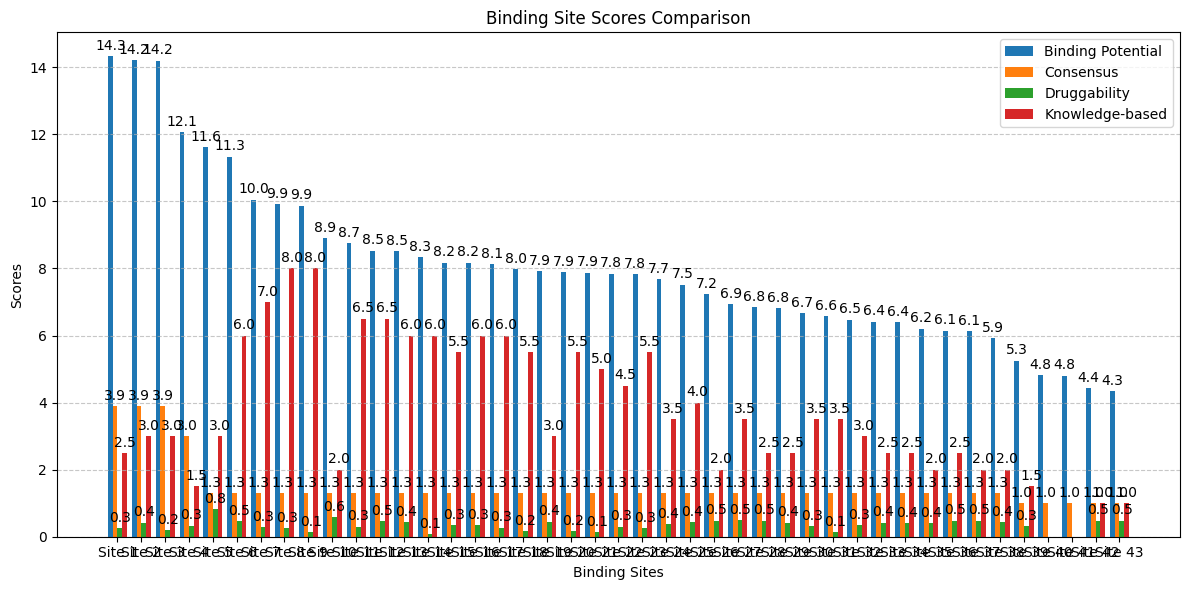

In [10]:
# Plot the binding site scores
if pockets:
    fig = plot_binding_site_scores(pockets)
    plt.show()

## Visualizing in PyMOL

ConSBind generates a PyMOL script for visualizing the binding sites. If PyMOL is installed, you can run this script directly from the notebook.

In [11]:
# Check if output files were created
if output_files:
    output_file, output_pdb, pymol_script = output_files
    print(f"Text summary: {output_file}")
    print(f"Modified PDB: {output_pdb}")
    print(f"PyMOL script: {pymol_script}")
    
    # Display the PyMOL command to visualize the results
    print("\nTo visualize the results, run the following command in a terminal:")
    print(f"pymol {pymol_script}")
else:
    print("No output files were created.")

Text summary: notebook_results_predictions.txt
Modified PDB: notebook_results_predicted.pdb
PyMOL script: notebook_results_pymol.pml

To visualize the results, run the following command in a terminal:
pymol notebook_results_pymol.pml


## Using ConSBind in Your Own Workflows

Now that you've seen how to use ConSBind programmatically, you can incorporate it into your own workflows. Here are some ideas:

1. Process multiple PDB files in batch
2. Compare binding site predictions with experimental data
3. Use binding site predictions as input for docking simulations
4. Develop custom visualization or analysis of binding sites

Here's a simple example of processing multiple PDB files:

In [13]:
def batch_process_pdb_files(pdb_directory, output_directory):
    """
    Process multiple PDB files in a directory
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Get all PDB files in the directory
    pdb_files = [f for f in os.listdir(pdb_directory) if f.endswith('.pdb')]
    
    print(f"Found {len(pdb_files)} PDB files in {pdb_directory}")
    
    results = {}
    
    for pdb_file in pdb_files:
        pdb_id = os.path.splitext(pdb_file)[0]
        pdb_path = os.path.join(pdb_directory, pdb_file)
        output_prefix = os.path.join(output_directory, pdb_id)
        
        print(f"\nProcessing {pdb_id}...")
        
        try:
            # Load protein structure
            protein = ProteinStructure(pdb_path)
            
            # Predict binding sites
            pockets, _ = predict_binding_sites(protein, output_prefix=output_prefix)
            
            # Store results
            results[pdb_id] = pockets
            
            print(f"Processed {pdb_id}: Found {len(pockets)} binding sites")
            
        except Exception as e:
            print(f"Error processing {pdb_id}: {str(e)}")
            results[pdb_id] = None
    
    return results

# Example usage (commented out)
batch_results = batch_process_pdb_files('data', 'results')

Found 3 PDB files in data

Processing 4dfr...


2025-03-24 19:47:16,009 - ConSBind.core.structure - INFO - Created grid with dimensions: 67x72x93


Step 1: Finding pockets using geometric approach...


2025-03-24 19:47:17,145 - ConSBind.core.structure - INFO - Found 775 potential cavity points
2025-03-24 19:47:17,152 - ConSBind.core.structure - INFO - Found 42 cavities after clustering
2025-03-24 19:47:17,153 - ConSBind.core.structure - INFO - Identified 1376 surface atoms
2025-03-24 19:47:17,154 - ConSBind.core.finder - INFO - Calculating energy scores for grid points...


Found 42 geometric pockets

Step 2: Finding pockets using energy-based approach...


2025-03-24 19:47:34,132 - ConSBind.core.finder - INFO - Found 40 high-energy points
2025-03-24 19:47:34,135 - ConSBind.core.finder - INFO - Found 5 energy-based pockets after clustering
2025-03-24 19:47:34,368 - ConSBind.core.finder - INFO - Combined into 43 consensus pockets


Found 5 energy-based pockets

Step 3: Combining results from different methods...
Combined into 43 consensus pockets

Step 4: Adjusting scores based on protein function...

Step 6: Saving predictions...


2025-03-24 19:47:34,603 - ConSBind.output.output - INFO - Predictions saved to results/4dfr_predictions.txt
2025-03-24 19:47:34,603 - ConSBind.output.output - INFO - Modified PDB saved to results/4dfr_predicted.pdb
2025-03-24 19:47:34,603 - ConSBind.output.output - INFO - PyMOL script saved to results/4dfr_pymol.pml


Predictions saved with prefix: results/4dfr
Processed 4dfr: Found 43 binding sites

Processing 1stp...


2025-03-24 19:47:35,928 - ConSBind.core.structure - INFO - Created grid with dimensions: 62x54x68


Step 1: Finding pockets using geometric approach...


2025-03-24 19:47:36,581 - ConSBind.core.structure - INFO - Found 381 potential cavity points
2025-03-24 19:47:36,583 - ConSBind.core.structure - INFO - Found 5 cavities after clustering
2025-03-24 19:47:36,583 - ConSBind.core.structure - INFO - Identified 601 surface atoms
2025-03-24 19:47:36,584 - ConSBind.core.finder - INFO - Calculating energy scores for grid points...


Found 5 geometric pockets

Step 2: Finding pockets using energy-based approach...


2025-03-24 19:47:42,925 - ConSBind.core.finder - INFO - Found 25 high-energy points
2025-03-24 19:47:42,926 - ConSBind.core.finder - INFO - Found 5 energy-based pockets after clustering
2025-03-24 19:47:42,934 - ConSBind.core.finder - INFO - Combined into 10 consensus pockets
2025-03-24 19:47:42,951 - ConSBind.output.output - INFO - Predictions saved to results/1stp_predictions.txt
2025-03-24 19:47:42,951 - ConSBind.output.output - INFO - Modified PDB saved to results/1stp_predicted.pdb
2025-03-24 19:47:42,952 - ConSBind.output.output - INFO - PyMOL script saved to results/1stp_pymol.pml


Found 5 energy-based pockets

Step 3: Combining results from different methods...
Combined into 10 consensus pockets

Step 4: Adjusting scores based on protein function...

Step 6: Saving predictions...
Predictions saved with prefix: results/1stp
Processed 1stp: Found 10 binding sites

Processing 1a01...


2025-03-24 19:47:44,612 - ConSBind.core.structure - INFO - Created grid with dimensions: 86x77x79


Step 1: Finding pockets using geometric approach...


2025-03-24 19:47:46,066 - ConSBind.core.structure - INFO - Found 938 potential cavity points
2025-03-24 19:47:46,070 - ConSBind.core.structure - INFO - Found 60 cavities after clustering
2025-03-24 19:47:46,071 - ConSBind.core.structure - INFO - Identified 2226 surface atoms
2025-03-24 19:47:46,071 - ConSBind.core.finder - INFO - Calculating energy scores for grid points...


Found 60 geometric pockets

Step 2: Finding pockets using energy-based approach...


2025-03-24 19:48:15,202 - ConSBind.core.finder - INFO - Found 53 high-energy points
2025-03-24 19:48:15,203 - ConSBind.core.finder - INFO - Found 3 energy-based pockets after clustering


Found 3 energy-based pockets

Step 3: Combining results from different methods...


2025-03-24 19:48:15,750 - ConSBind.core.finder - INFO - Combined into 58 consensus pockets


Combined into 58 consensus pockets

Step 4: Adjusting scores based on protein function...

Step 6: Saving predictions...


2025-03-24 19:48:16,269 - ConSBind.output.output - INFO - Predictions saved to results/1a01_predictions.txt
2025-03-24 19:48:16,269 - ConSBind.output.output - INFO - Modified PDB saved to results/1a01_predicted.pdb
2025-03-24 19:48:16,270 - ConSBind.output.output - INFO - PyMOL script saved to results/1a01_pymol.pml


Predictions saved with prefix: results/1a01
Processed 1a01: Found 58 binding sites


## Conclusion

In this tutorial, you've learned how to use ConSBind programmatically to predict binding sites in protein structures. You've seen how to:

1. Load protein structures
2. Run the binding site prediction workflow
3. Access and analyze the prediction results
4. Create visualizations of the binding sites
5. Set up batch processing for multiple proteins

This programmatic approach allows you to integrate ConSBind into larger workflows and custom analyses, making it a versatile tool for structural bioinformatics.